# Table of Contents

* [Project Libraries](#project_libraries)
* [Creating Spark Instance](#creating_spark_instance)
* [Importing Data](#importing_data)
* [EDA](#eda)
    * [Origin and Destination Aiport Counts](#orig_dest_airport_counts)
    * [Correlation Matrix](#correlation_matrix)
    * [Pairplot](#pairplot)
    * [Summary Table](#summary_table)
    * [Null Counts](#null_counts)
* [Dataset for Modeling](#dataset_modeling)
    * [Feature Engineering](#feature_engineering)
* [Stratified Sampling: Train Test Split](#stratified_train_test_split)
* [Modeling](#modeling)
    * [Base Model](#base_model)
    * [Model by Airport (If time)](#model_by_airport)
    * [Model by Airline (If time)](#model_by_airline)
* [Model Summaries](#model_summary)
    * [Best Model](#best_model)
* [Stop Spark Session](#stop_spark_session)


# Libraries <a class="anchor" id="project_libraries"></a>

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.sql.functions import col,isnan, when, count
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image

# Creating Spark Instance <a class="anchor" id="creating_spark_instance"></a>

In [2]:
conf = pyspark.SparkConf().setAll([
        ('spark.master',   'local[*]'),
        ('spark.app.name', 'PySpark Plane Data')])

# Schema for original data set
schema = StructType([StructField("YEAR", StringType(), False),
                        StructField("MONTH", StringType(), False),
                        StructField("DAY", StringType(), False),
                        StructField("DAY_OF_WEEK", StringType(), False),
                        StructField("AIRLINE", StringType(), False),
                        StructField("FLIGHT_NUMBER", StringType(), True),
                        StructField("TAIL_NUMBER", StringType(), True),
                        StructField("ORIGIN_AIRPORT", StringType(), False),
                        StructField("DESTINATION_AIRPORT", StringType(), False),
                        StructField("SCHEDULED_DEPARTURE", IntegerType(), False),
                        StructField("DEPARTURE_TIME", IntegerType(), True),
                        StructField("DEPARTURE_DELAY", IntegerType(), True),
                        StructField("TAXI_OUT", IntegerType(), True),
                        StructField("WHEELS_OFF", IntegerType(), True),
                        StructField("SCHEDULED_TIME", IntegerType(), True),
                        StructField("ELAPSED_TIME", IntegerType(), True),
                        StructField("AIR_TIME", IntegerType(), True),
                        StructField("DISTANCE", IntegerType(), True),
                        StructField("WHEELS_ON", IntegerType(), True),
                        StructField("TAXI_IN", IntegerType(), True),
                        StructField("SCHEDULED_ARRIVAL", IntegerType(), True),
                        StructField("ARRIVAL_TIME", IntegerType(), True),
                        StructField("ARRIVAL_DELAY", IntegerType(), True),
                        StructField("DIVERTED", StringType(), True),
                        StructField("CANCELLED", StringType(), True),
                        StructField("CANCELLATION_REASON", StringType(), True),
                        StructField("AIR_SYSTEM_DELAY", IntegerType(), True),
                        StructField("SECURITY_DELAY", IntegerType(), True),
                        StructField("AIRLINE_DELAY", IntegerType(), True),
                        StructField("LATE_AIRCRAFT_DELAY", IntegerType(), True),
                        StructField("WEATHER_DELAY", StringType(), True),
                    ])

# Importing Data <a class="anchor" id="importing_data"></a>

In [4]:
# Creating Spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()
df = spark.read.csv("/Users/CarlosMonsivais/Desktop/dse230_plane/flight-delays/flights.csv",
                    header=True,
                    schema = schema)

In [5]:
df.show(2)

22/05/03 12:35:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+--------+---------+-------+-----------------+------------+-------------+--------+---------+-------------------+----------------+--------------+-------------+-------------------+-------------+
|YEAR|MONTH|DAY|DAY_OF_WEEK|AIRLINE|FLIGHT_NUMBER|TAIL_NUMBER|ORIGIN_AIRPORT|DESTINATION_AIRPORT|SCHEDULED_DEPARTURE|DEPARTURE_TIME|DEPARTURE_DELAY|TAXI_OUT|WHEELS_OFF|SCHEDULED_TIME|ELAPSED_TIME|AIR_TIME|DISTANCE|WHEELS_ON|TAXI_IN|SCHEDULED_ARRIVAL|ARRIVAL_TIME|ARRIVAL_DELAY|DIVERTED|CANCELLED|CANCELLATION_REASON|AIR_SYSTEM_DELAY|SECURITY_DELAY|AIRLINE_DELAY|LATE_AIRCRAFT_DELAY|WEATHER_DELAY|
+----+-----+---+-----------+-------+-------------+-----------+--------------+-------------------+-------------------+--------------+---------------+--------+----------+--------------+------------+--------+-

In [6]:
# Data Shape
print('There are {} rows and {} columns in the data'.format(df.count(), len(df.columns)))

There are 5819079 rows and 31 columns in the data


# EDA <a class="anchor" id="eda"></a>

## Origin and Destination Aiport Counts <a class="anchor" id="orig_dest_airport_counts"></a>

In [7]:
# Top 5 airports with planes outbound
origin_airport_count = df.groupBy('ORIGIN_AIRPORT').count().orderBy('count', ascending=False)

# Top 5 airports with planes inbound
destination_airport_count = df.groupBy('DESTINATION_AIRPORT').count().orderBy('count', ascending=False)

In [8]:
fig = make_subplots(rows=2, 
                    cols=1,
                    subplot_titles=("Origin Airport Counts", "Destination Airport Counts"))

fig.add_trace(go.Bar(x = origin_airport_count.toPandas()['ORIGIN_AIRPORT'].astype(str), 
                        y = origin_airport_count.toPandas()['count']),
                row=1, col=1)

fig.add_trace(go.Bar(x = destination_airport_count.toPandas()['DESTINATION_AIRPORT'].astype(str), 
                        y = destination_airport_count.toPandas()['count']),
                row=2, col=1)

fig.update_xaxes(title_text = "Origin Aiport", row=1, col=1)
fig.update_xaxes(title_text = "Destination Aiport", row=2, col=1)

fig.update_yaxes(title_text = "Count", row=1, col=1)
fig.update_yaxes(title_text = "Count", row=2, col=1)

fig.update_layout(height=900, width = 1400, showlegend=False)
fig.write_image("/Users/CarlosMonsivais/Desktop/dse230_plane/EDA_Static_Images/Origin_Destination_Airport_Count.png")

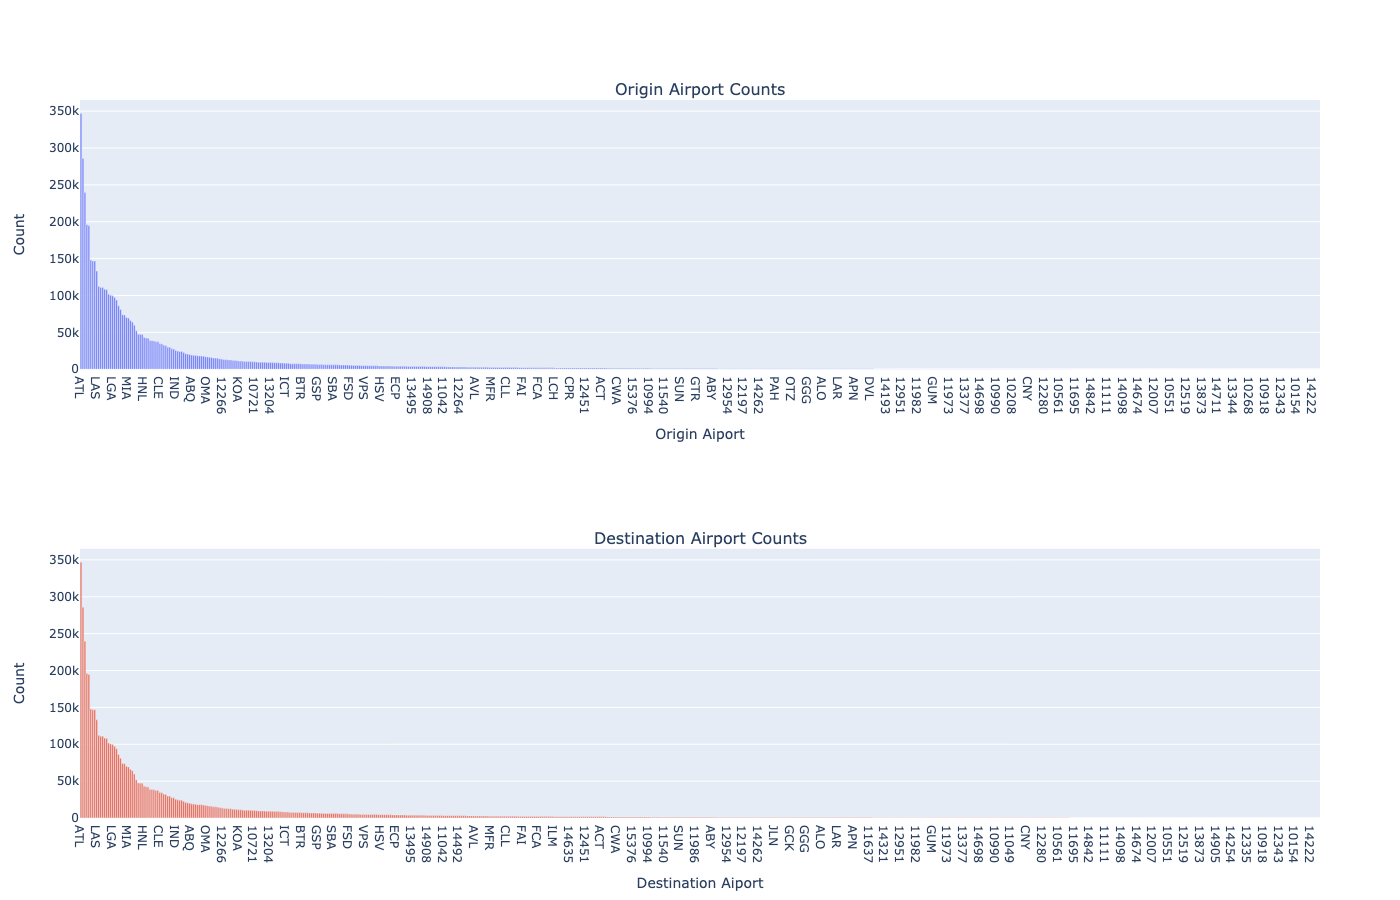

In [9]:
Image(filename="/Users/CarlosMonsivais/Desktop/dse230_plane/EDA_Static_Images/Origin_Destination_Airport_Count.png")

## Correlation Matrix <a class="anchor" id="correlation_matrix"></a>

In [10]:
integer_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, IntegerType)]
integer_df = df[[integer_cols]]
integer_df_drop_na = integer_df.na.drop("any")

vector_col = "corr_features"
assembler = VectorAssembler(inputCols = integer_df_drop_na.columns, 
                            outputCol = vector_col)
df_vector = assembler.transform(integer_df_drop_na).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)
matrix_array = matrix.collect()[0]["pearson({})".format(vector_col)].values
matrix_array = matrix_array.reshape((len(integer_cols), len(integer_cols)))

22/05/03 12:37:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/05/03 12:37:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/Users/CarlosMonsivais/Desktop/dse230_plane/pyspark_230_env/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



In [11]:
fig = go.Figure(data=go.Heatmap(z = matrix_array,
                                x = integer_cols,
                                y = integer_cols,
                                text = np.round(matrix_array, 2),
                                texttemplate="%{text}",
                                hoverongaps = False))
fig.update_layout(title={'text': "Correlation Plot",
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'},
                    yaxis_nticks=len(integer_cols),
                    xaxis_nticks=len(integer_cols))
fig.update_layout(height=900, width = 1400, showlegend=False)
fig.write_image("/Users/CarlosMonsivais/Desktop/dse230_plane/EDA_Static_Images/Correlation_Plot.png")

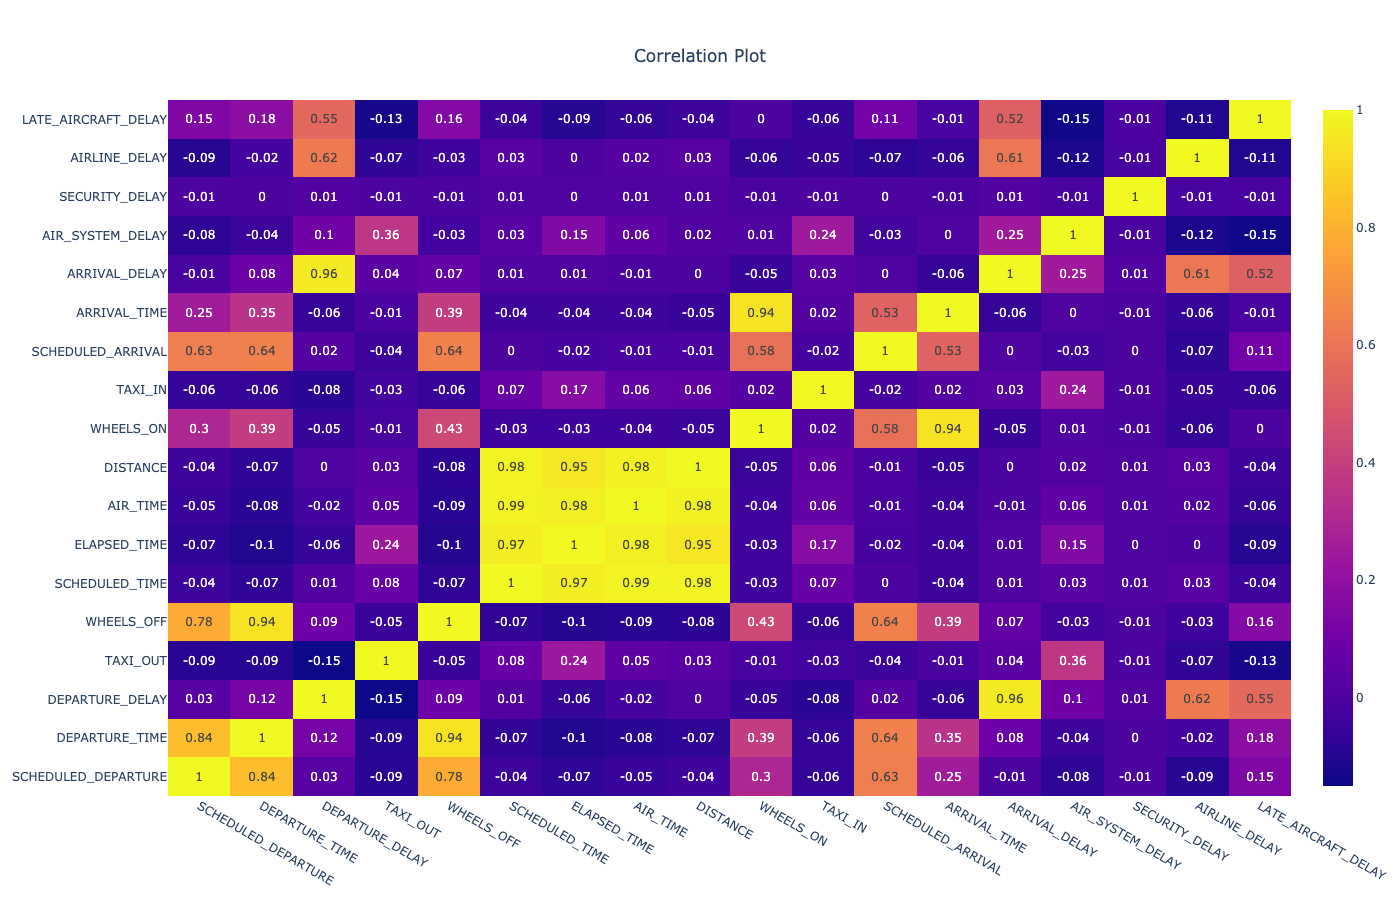

In [12]:
Image(filename="/Users/CarlosMonsivais/Desktop/dse230_plane/EDA_Static_Images/Correlation_Plot.png")

## Pairplot <a class="anchor" id="pairplot"></a>

In [13]:
pairplot = df.limit(2000)

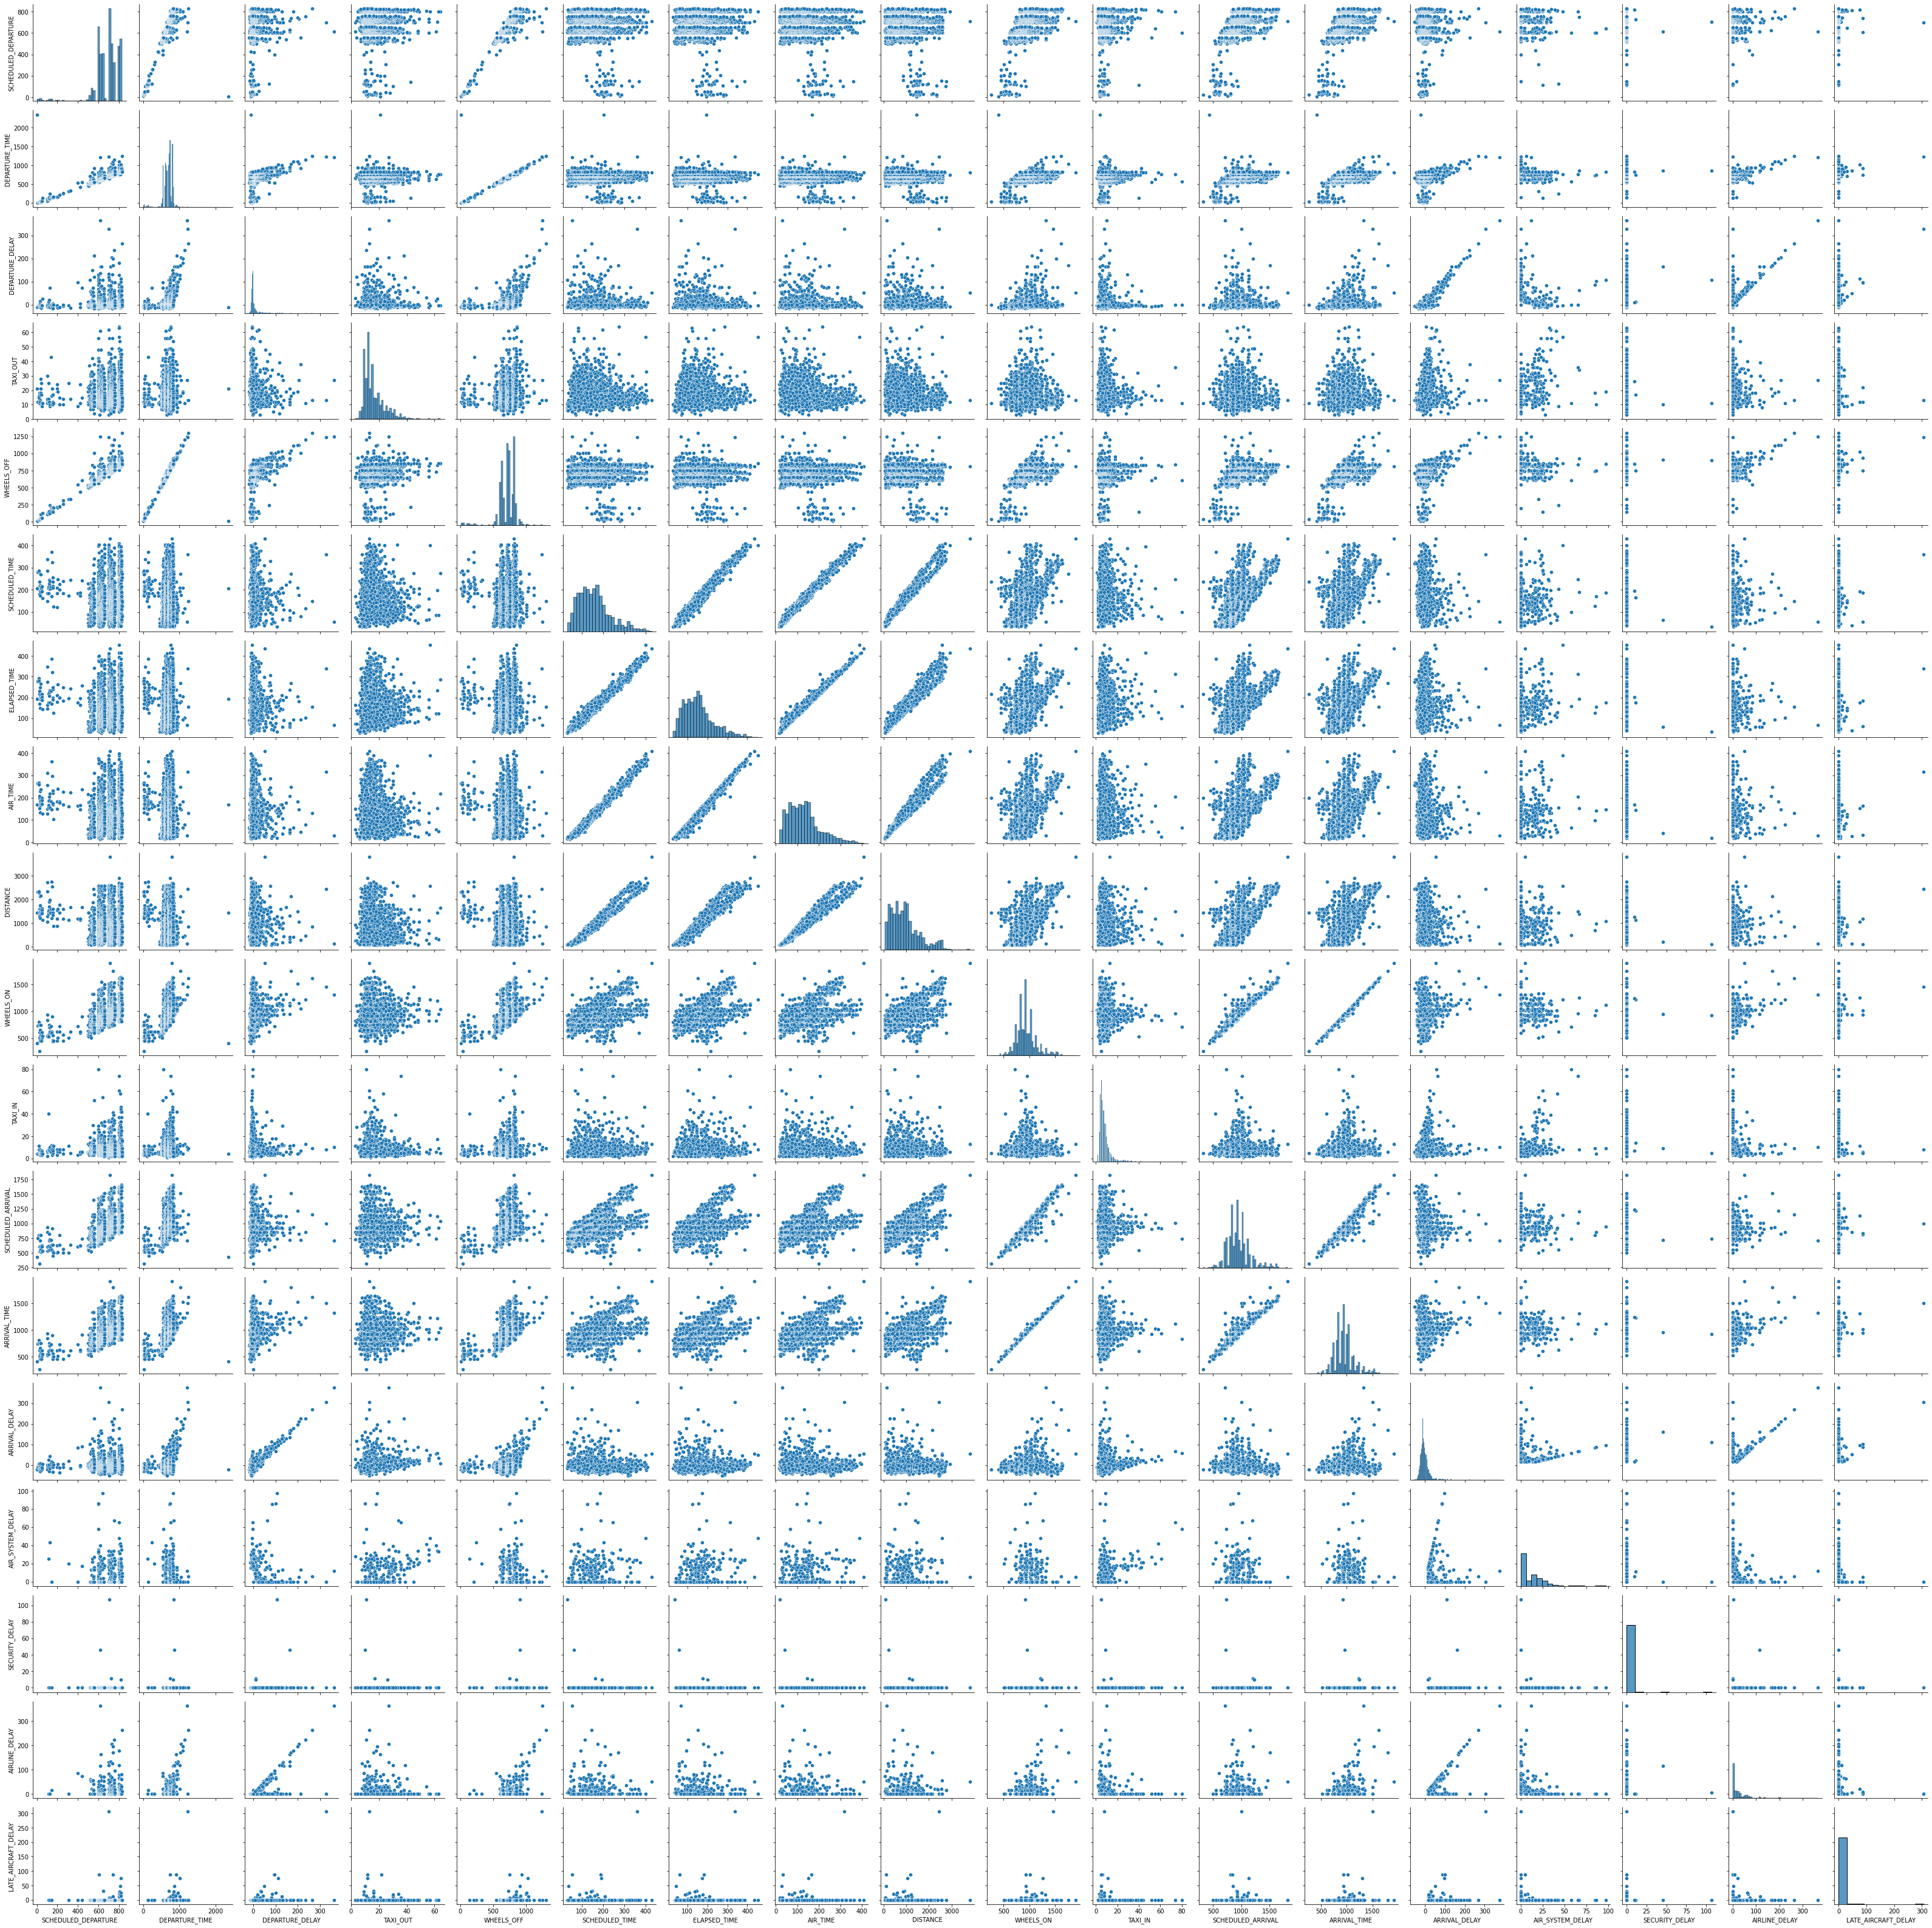

<Figure size 432x288 with 0 Axes>

In [14]:
fig = sns.PairGrid(pairplot.toPandas())
fig.map_diag(sns.histplot)
fig.map_offdiag(sns.scatterplot)
plt.show(block=False)
plt.savefig('/Users/CarlosMonsivais/Desktop/dse230_plane/EDA_Static_Images/Pairplot.png')

## Summary Table <a class="anchor" id="summary_table"></a>

In [15]:
summary_table = df.summary()
pandas_summary = summary_table.toPandas()

In [16]:
summary_pandas_df = pandas_summary.T
summary_pandas_df.rename(columns = summary_pandas_df.iloc[0], inplace = True)
summary_pandas_df_table = summary_pandas_df.iloc[1:]
summary_pandas_df_table.reset_index(inplace = True, drop = False)
summary_pandas_df_table.rename(columns={summary_pandas_df_table.columns[0]: "Columns" }, inplace = True)
summary_pandas_df_table['mean'] = summary_pandas_df_table['mean'].astype(float)
summary_pandas_df_table['mean'] = summary_pandas_df_table['mean'].round(2)
summary_pandas_df_table['stddev'] = summary_pandas_df_table['stddev'].astype(float)
summary_pandas_df_table['stddev'] = summary_pandas_df_table['stddev'].round(2)

/var/folders/qt/01h0bbdx0d3_s2vp3lwhpj3m0000gn/T/ipykernel_16230/3752246127.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qt/01h0bbdx0d3_s2vp3lwhpj3m0000gn/T/ipykernel_16230/3752246127.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/qt/01h0bbdx0d3_s2vp3lwhpj3m0000gn/T/ipykernel_16230/3752246127.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [17]:
fig = go.Figure(data=[go.Table(header=dict(values=list(summary_pandas_df_table.columns)),
                cells=dict(values=[summary_pandas_df_table['Columns'],
                                   summary_pandas_df_table['count'],
                                   summary_pandas_df_table['mean'],
                                   summary_pandas_df_table['stddev'],
                                   summary_pandas_df_table['min'],
                                   summary_pandas_df_table['25%'],
                                   summary_pandas_df_table['50%'],
                                   summary_pandas_df_table['75%'],
                                   summary_pandas_df_table['max']],
                            font_size=9       
                                    ))])
fig.update_layout(width=1400,
                  height=850)
fig.write_image("/Users/CarlosMonsivais/Desktop/dse230_plane/EDA_Static_Images/Summary_Table.png")

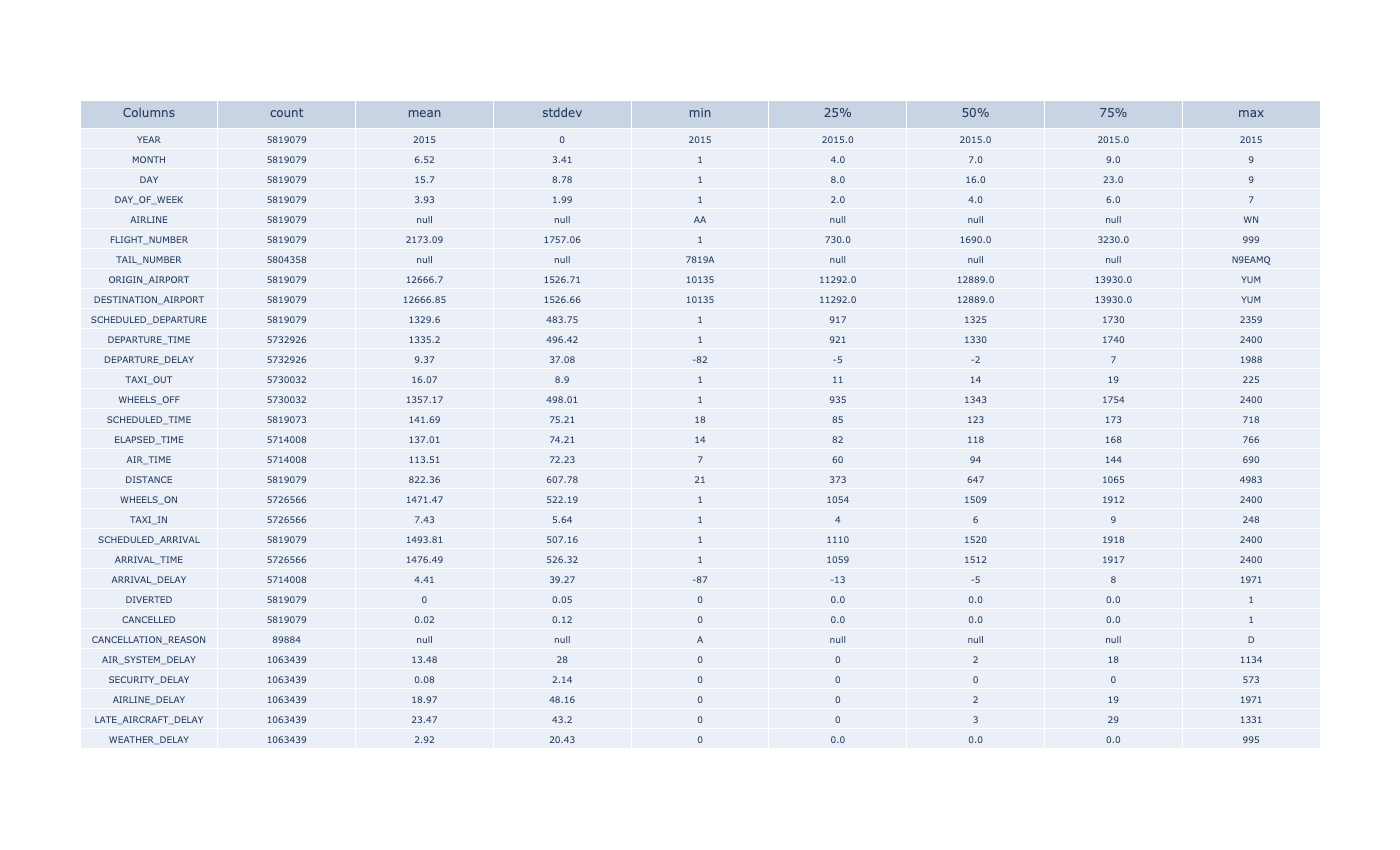

In [18]:
Image(filename="/Users/CarlosMonsivais/Desktop/dse230_plane/EDA_Static_Images/Summary_Table.png")

## Null Counts <a class="anchor" id="null_counts"></a>

In [19]:
null_counts_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts_pandas = null_counts_df.toPandas()

In [20]:
fig = go.Figure(data=[go.Bar(x = list(null_counts_pandas.columns), 
                             y = null_counts_pandas.values.tolist()[0],
                                text = null_counts_pandas.values.tolist()[0],
                                textposition = 'auto')])
fig.update_layout(title={'text': "Null Value Count",
                        'x':0.5,
                        'xanchor': 'center',
                        'yanchor': 'top'},
                xaxis_title = "Column Names",
                yaxis_title = "Null Counts")                            
fig.update_layout(height=900, width = 1400, showlegend=False)
fig.write_image("/Users/CarlosMonsivais/Desktop/dse230_plane/EDA_Static_Images/Null_Values.png")

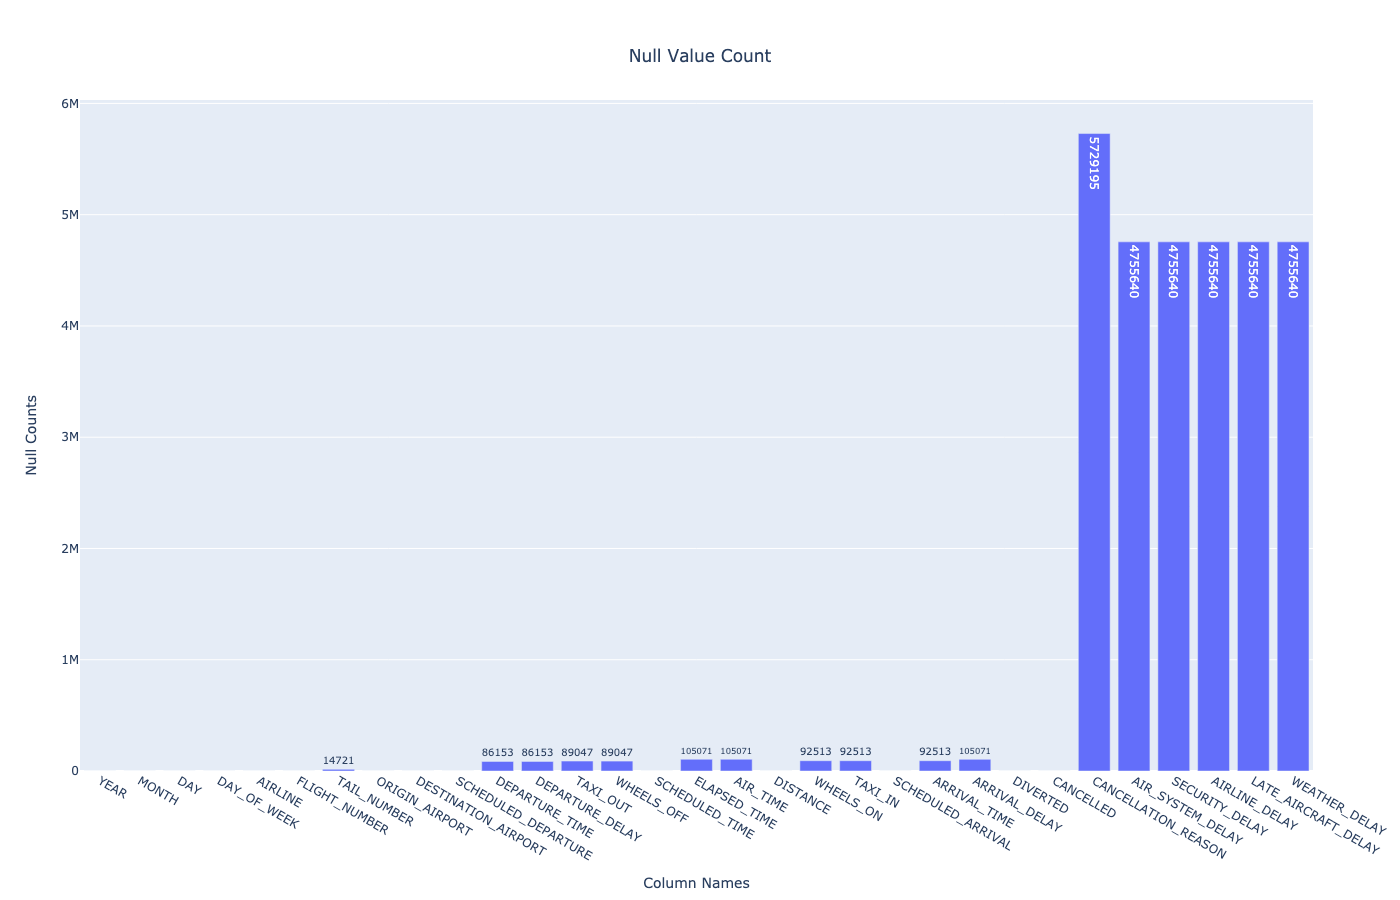

In [21]:
Image(filename="/Users/CarlosMonsivais/Desktop/dse230_plane/EDA_Static_Images/Null_Values.png")

# Dataset for Modeling <a class="anchor" id="dataset_modeling"></a>

## Feature Engineering <a class="anchor" id="feature_engineering"></a>

# Stratified Sampling: Train Test Split <a class="anchor" id="stratified_train_test_split"></a>

# Modeling <a class="anchor" id="modeling"></a>

## Base Model <a class="anchor" id="base_model"></a>

## Model by Airport (If time) <a class="anchor" id="model_by_airport"></a>

## Model by Airline (If time) <a class="anchor" id="model_by_airline"></a>

# Model Summaries <a class="anchor" id="model_summary"></a>

## Best Model <a class="anchor" id="best_model"></a>

# Stop Spark Session <a class="anchor" id="stop_spark_session"></a>

In [22]:
spark.stop()